In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools as ft
from numbers import Number

In [3]:
# Setting up the board

NUM_SPACES = 40
JAIL_SPACE = 10
GOTO_JAIL_SPACE = 30

# Spaces on the board. All properties have dashes
SPACES = ["GO", "BRW-Medit", "CC1", "BRW-Baltic", "TAX_Income", "RR-Read", "WHT-Orient",
          "Chance1", "WHT-Verm", "WHT-Connec", "Jail", "PUR-StChar", "UTL-Elect", "PUR-States",
          "PUR-Virg", "RR-Penn", "ORG-StJames", "CC2", "ORG-Tenn", "ORG-NY", "Free_Parking",
          "RED-Kent", "Chance2", "RED-Indiana", "RED-Illi", "RR-B&O", "YEL-Atlantic",
          "YEL-Vent", "UTL-Water", "YEL-Marv", "GoToJail", "GRE-Pacific", "GRE-NC", "CC3",
          "GRE-Penn", "RR-SHLine", "Chance3", "BLU-ParkPl", "TAX_Luxury", "BLU-Boardwalk"]

# Finds the Chance/CC spaces using patterns
CHANCE_SPACES = np.where(["Chance" in s for s in SPACES])[0]
CC_SPACES = np.where(["CC" in s for s in SPACES])[0]
UTL_SPACES = np.where(["UTL-" in s for s in SPACES])[0]

# Chance/ Community Chest Decks
# A Number: Sends you to that space. B3 moves backwards 3
# Util, RR, Jail: Advances to nearest Railroad, Utility, or Go to Jail
# Jailfree: Gets you a get out of jail for free card. 
# NA: Does nothing. These cards are just payment in game. This simulation does not deal with payments
CHANCE_DECK = [0, 24, 11, "Util", "RR", "NA", "JailFree", "B3", "Jail", "NA", "NA", 5,
              39, "NA", "NA", "NA"]

CC_DECK = np.concatenate(([0, "JailFree", "Jail"], np.repeat("NA", 13)))

In [4]:
# For future reference, here's the key of space numbers to acutal places:
spacelist = [str(x) + " " + SPACES[x] for x in range(NUM_SPACES)]
# spacelist

[2, 0, 3, 2, 2, 0, 1, 2, 0, 2, 1, 2, 2, 2, 1]


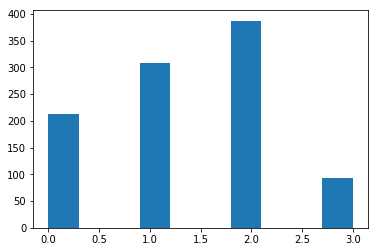

In [5]:
# Stuff to define. Random variabule N()

#  What is the maximum number of turns you're willing to roll before paying out of jail?
#  Simulation will generate a new N() before going to jail. 
#  N() is 1, then you'll pay after rolling once. 
#  Note that N <= 3 because you HAVE to pay after the third roll
PROB_PAY = [.2, .3, .4, .1]

def N():
    return np.random.choice(range(4),1, p=PROB_PAY)[0]

# Example: 15 Random Values and histogram:
print([N() for x in range(15)])
plt.hist([N() for x in range(1000)])
plt.show()

In [6]:
# Dice Rolls. Returns sum of dice and if it was a double
def rollDice():
    rs = np.random.choice(range(1,7) , 2, replace=True)
    return [sum(rs), rs[0] == rs[1]]

# Example
# plt.hist([rollDice()[0] for x in range(1000)], bins=11)
# plt.show()

In [7]:
# Space number Calculators. (These are measured in total distance moved)

# Find the nearest RR (round to nearest 5)
def nearestRR(space):
    return int(np.ceil((space+5)/10)*10-5)


# Nearest Utility @ space 28 and 12. ***Maybe make this more robust with arrays
def nearestUtil(space):
    rounds = np.floor(space / NUM_SPACES)
    sp = space % NUM_SPACES
    if (sp > 12 and sp <= 28):
        return int(28 + rounds*NUM_SPACES)
    elif (sp >28):
        return int(12+(rounds+1)*NUM_SPACES)
    else:
        return int(12 + rounds*NUM_SPACES)

# Returns final location after moving from current spot to a particular space
def goToSpace(curr, space):
    return int(np.ceil((curr - space) / NUM_SPACES)*NUM_SPACES + space)

# # Example
# print(nearestRR(39))
# print(goToSpace(23, 11))

In [8]:
# Deck Drawing

# Returns the (0) resulting movement after drawing a chance card,
# (1) if they are jailed, (2) if they got a jail-free card, (3) the drawn deck, and a string record of what happened
# Will draw without replacement and reshuffle deck when all cards are gone. 
def drawDeck(typDeck, deck, curr):
    assert typDeck == "CHANCE" or typDeck == "CC", "ERROR: Invalid type of deck!"
    if typDeck.upper() == "CHANCE":
        basedeck = CHANCE_DECK
    elif typDeck.upper() == "CC":
        basedeck = CC_DECK
    s = ""
    if len(deck) == 0:  # Reset and Shuffle the Deck
        s += "{} Deck is empty. Reshuffling Deck!".format(typDeck) + "\n"
        deck.extend(basedeck)
    result = [np.nan, False, 0, deck]

    card = deck[np.random.randint(0,len(deck),1)[0]]
    if isinstance(card, Number):
        result[:2] = [goToSpace(curr, card), False]
        s += "Card Drawn: Advance to {} (Space {})".format(SPACES[result[0] % NUM_SPACES], result[0] % NUM_SPACES) + "\n"
    elif card == "Util":
        s += "Card drawn: Advance to nearest Utility" + "\n"
        result[0] = nearestUtil(curr)
    elif card == "RR":
        s += "Card drawn: Advance to nearest Railroad" + "\n"
        result[0] = nearestRR(curr)
    elif card == "B3":
        s += "Card drawn: Move backward 3 spaces" + "\n"
        result[0] = curr - 3
    elif card == "Jail":
        s += "Card drawn: Go to Jail!" + "\n"
        result[0] = goToSpace(curr, JAIL_SPACE)
        result[1] = True
    elif card == "JailFree":
        result[2] = 1
    else:
        s += "Card drawn: Payment (no movement)" + "\n"
    deck.remove(card)
    return result, s

# Explicit functions
def drawChance(deck, curr):
    return drawDeck("CHANCE", deck, curr)

def drawCC(deck, curr):
    return drawDeck("CC", deck, curr)

In [9]:
# CheckSpace function. Checks for anything happening at current space (x)

# Drawing Decks
chdeck = CHANCE_DECK[:]
ccdeck = list(CC_DECK)

# Returns (0) additional spaces moved, (1) if they were jailed, and (2) # of drawn get out of jail cards, and (3) a script.
def checkSpace(x, chdeck, ccdeck, jail_free):
    spaces = np.array([])
    space = x % NUM_SPACES
    jailed = False
    s = ""

    things_to_check = [space in CHANCE_SPACES, space in CC_SPACES, space == GOTO_JAIL_SPACE]
    while sum(things_to_check) > 0:
        if things_to_check[0] or things_to_check[1]:
            if things_to_check[0]:
                s += "Chance! Draw chance card!" + "\n"
                res, r = drawChance(chdeck, x)
                s += r
                typ = "Chance"
                things_to_check[0] = False
            else:
                s += "Community Chest! Draw community chest card!" + "\n"
                res, r = drawCC(ccdeck, x)
                s += r
                typ = "CC"
                things_to_check[1] = False
            if isinstance(res[0], int):
                x = res[0]
                spaces = np.append(spaces, x)
                s += "Moved to space {} ({}): {} ".format(x % NUM_SPACES, x, SPACES[x % NUM_SPACES]) + "\n"
            if res[1]:  # JAILED
                jailed = True
                s += "You are now Jailed!" + "\n"
            if res[2] == 1:
                jail_free += res[2]
                s += "You got a get out of jail free card! You now have {} total".format(jail_free) + "\n"
            chdeck = res[3]
            s += "{} Deck: {} of {} cards left".format(typ, len(chdeck), len(CHANCE_DECK))+ "\n"
            if res[0] is np.nan:
                return [spaces, jailed, jail_free, s]

        if things_to_check[2]:
            s += "Ouch! Go directly to jail!" + "\n"
            x = goToSpace(x, JAIL_SPACE)
            s += "Moved to space {} ({}): {} ".format(x % NUM_SPACES, x, SPACES[x % NUM_SPACES]) + "\n"
            spaces = np.append(spaces, x)
            jailed = True
            s += "You are now Jailed!" + "\n"
            return [spaces.astype(np.int64), jailed, jail_free, s]

        space = x % NUM_SPACES
        things_to_check = [space in CHANCE_SPACES, space in CC_SPACES, space == GOTO_JAIL_SPACE]

    if not jailed and jail_free == 0 and sum(things_to_check) == 0:
        s += "Nothing to see here...." + "\n"

    return [spaces.astype(np.int64), jailed, jail_free, s]

In [10]:
# Example of CheckSpace. You have to print s to have it formatted nice.
# Repeatly run this to also see reshuffling feature

# Space 22 - Chance
r = checkSpace(22, chdeck, ccdeck, 0)
print(r[:3])
print("\n" + r[3])

# Space 1
print(checkSpace(1, chdeck, ccdeck, 0))

[array([], dtype=float64), False, 0]

Chance! Draw chance card!
Card drawn: Payment (no movement)
Chance Deck: 15 of 16 cards left

[array([], dtype=int64), False, 0, 'Nothing to see here....\n']


In [11]:
# Simulation with statistical results

def sim(nTurns, curr_space=0, jailed=False):
    jail_free = 0
    non_dubs = 0
    num_dubs = 0
    n = N()
    spaces = np.array([curr_space])
    recs = []

    movement = np.array([])
    jailed_turns = 0
    still_jailed = 0
    paid_jailed = 0
    dubs_jailed = 0
    jailfree_jailed = 0
    back_in_jail = []
    jailed_spaces = []
    jailed_spaces_curr = []
    go_skips = 0
    jail_cards = []

    chdeck = CHANCE_DECK[:]
    ccdeck = list(CC_DECK)
    
    for turn in range(nTurns):
        s = ""
        s += "Turn #{}: ".format(turn+1) + "\n"
        start_space = curr_space
        jail_cards.append(jail_free)
        got_outjail = False
        if jailed:
            assert curr_space % NUM_SPACES == JAIL_SPACE, "ERROR: You must be on the jail space to be jailed"
        assert curr_space % NUM_SPACES != GOTO_JAIL_SPACE, "ERROR: You can't start on the Go to Jail space"
    
        s += "You have {} get out of jail free card(s)".format(jail_free) + "\n"
        # print(str(type(curr_space)) + " " + str(curr_space))
        s += "Starting at space {} ({}): {} ".format(curr_space % NUM_SPACES, curr_space, SPACES[curr_space % NUM_SPACES]) + "\n"
    
        if jail_free > 0 and jailed:
            s += "You are Jailed!" + "\n"
            jailed_turns += 1
            jail_free -= 1
            s += "You used a get out of Jail Free card! {} jail-free cards left".format(jail_free) + "\n"
            s += "You are out of Jail!" + "\n"
            got_outjail = True
            jailfree_jailed += 1
            jailed = False
    
        if jailed:
            # Roll out of jail
            s += "You are Jailed!" + "\n"
            s += "You've rolled {} out of a max of {} rolls before you'll pay.".format(non_dubs, n) + "\n"
            jailed_turns += 1
            if non_dubs < n:
                roll = rollDice()
                if roll[1]:
                    s += "You got out of jail! You rolled a double! Move {} spaces".format(roll[0]) + "\n"
                    got_outjail = True
                    jailed = False
                    dubs_jailed += 1
                    curr_space += roll[0]
                    s += "Moved to space {} ({}): {} ".format(curr_space % NUM_SPACES, curr_space, SPACES[curr_space % NUM_SPACES]) + "\n"
                    spaces = np.append(spaces, curr_space).astype(np.int64)
                    # Check Space
                    s += "Checking Space..." + "\n"
                    cs = checkSpace(curr_space, chdeck, ccdeck, jail_free)
                    if len(cs[0]) != 0:
                        curr_space = cs[0][-1]  # Last number of the sequence becomes current space
                    spaces = np.concatenate((spaces, cs[0]))
                    jailed = cs[1]
                    jail_free = cs[2]
                    non_dubs = 0
                    n = N()
                    s += cs[3]
                    if jailed:
                        back_in_jail.append(turn)
                        s += "Back in Jail!" + "\n"
                        jailed_spaces.append(start_space)
                        jailed_spaces_curr.append(spaces[-2])
                        if spaces[-2] % NUM_SPACES > JAIL_SPACE:
                            go_skips += 1
                            s += "Skipped Go!" + "\n"
                    s += "Next time you'll roll a max number of {} times to get out of jail".format(n) + "\n\n"
                    recs.append(s)
                    movement = np.append(movement, curr_space - start_space)
                    continue
                else:
                    non_dubs += 1
                    still_jailed += 1
                    s += "Still in Jail! Did not roll a double. So far, tried {} times".format(non_dubs) + "\n"
    
            else:
                s += "You've hit your max number of turns. Pay to get out of Jail!".format(non_dubs) + "\n"
                jailed=False
                paid_jailed += 1
                s += "You are now a free citizen (out of jail)!" + "\n"
                got_outjail = True
                non_dubs = 0
                n = N()
                s += "Next time you'll roll a max number of {} times to get out of jail".format(n) + "\n"
    
        if not jailed:
            num_dubs = 0
            roll = rollDice()
            s += "Rolled a dice total of {}".format(roll[0]) + "\n"
            if roll[1]:
                num_dubs = 1
                s += "Double! #{}".format(num_dubs) + "\n"
            curr_space += roll[0]
            s += "Moved to space {} ({}): {} ".format(curr_space % NUM_SPACES, curr_space, SPACES[curr_space % NUM_SPACES]) + "\n"
            spaces = np.append(spaces, curr_space)
            # Check Space
            s += "Checking Space..." + "\n"
            cs = checkSpace(curr_space, chdeck, ccdeck, jail_free)
            if len(cs[0]) != 0:
                curr_space = cs[0][-1]  # Last number of the sequence becomes current space
            spaces = np.concatenate((spaces, cs[0]))
            jailed = cs[1]
            s += cs[3]
            if jailed:
                if got_outjail:
                    s += "Back in Jail!" + "\n"
                    back_in_jail.append(turn)
                if spaces[-2] % NUM_SPACES > JAIL_SPACE:
                    go_skips += 1
                    s += "Skipped Go!" + "\n"
                jailed_spaces.append(start_space)
                jailed_spaces_curr.append(spaces[-2])
                movement = np.append(movement, curr_space - start_space)
                s += "\n"
                recs.append(s)
                continue
            jail_free = cs[2]
    
            while roll[1]:        # If you rolled a double
                roll = rollDice()
                s += "Rolled a dice total of {}".format(roll[0]) + "\n"
                if roll[1]:
                    num_dubs += 1
                    s += "Double! #{}".format(num_dubs) + "\n"
                if (num_dubs < 3):
                    curr_space += roll[0]
                    s += "Moved to space {} ({}): {} ".format(curr_space % NUM_SPACES, curr_space, SPACES[curr_space % NUM_SPACES]) + "\n"
                    spaces = np.append(spaces, curr_space)
                    # Check Space
                    s += "Checking Space..." + "\n"
                    cs = checkSpace(curr_space, chdeck, ccdeck, jail_free)
                    if len(cs[0]) != 0:
                        curr_space = cs[0][-1]  # Last number of the sequence becomes current space
                    spaces = np.concatenate((spaces, cs[0]))
                    s += cs[3]
                    jailed = cs[1]
                    if jailed:
                        if got_outjail:
                            s += "Back in Jail!" + "\n"
                            back_in_jail.append(turn)
                        if spaces[-2] % NUM_SPACES > JAIL_SPACE:
                            go_skips += 1
                            s += "Skipped Go!" + "\n"
                        jailed_spaces.append(start_space)
                        jailed_spaces_curr.append(spaces[-2])
                        break
                    jail_free = cs[2]
                else:  # JAILED
                    s += "Crap! 3 Doubles in a row!" + "\n"
                    curr_space = goToSpace(curr_space, JAIL_SPACE)
                    s += "Moved to space {} ({}): {} ".format(curr_space % NUM_SPACES, curr_space, SPACES[int(curr_space % NUM_SPACES)]) + "\n"
                    spaces = np.append(spaces, curr_space)
                    jailed = True
                    if spaces[-2] % NUM_SPACES > JAIL_SPACE:
                        go_skips += 1
                        s += "Skipped Go!" + "\n"
                    s += "You are now Jailed!" + "\n"
                    if got_outjail:
                        s += "Back in Jail!" + "\n"
                        back_in_jail.append(turn)
                    jailed_spaces.append(start_space)
                    jailed_spaces_curr.append(spaces[-2])
                    break
        movement = np.append(movement, curr_space - start_space)
        recs.append(s)

    # Jail Statistics. Check to make sure we don't divide by zero
    if jailed_turns == 0:
        jail1stats = [0]*4
    else:
        jail1stats = np.array([still_jailed, paid_jailed, dubs_jailed, jailfree_jailed]) / jailed_turns
    if jailed_turns-still_jailed == 0:
        jail2stat = [0]
    else:
        jail2stat = [len(back_in_jail)/(jailed_turns-still_jailed)]
    jail_stat = np.concatenate(([jailed_turns/nTurns], jail1stats, jail2stat))

    collect_go = int(spaces[-1] // NUM_SPACES - go_skips)
    collect_go = [collect_go, nTurns / collect_go]

    return [spaces, movement, jail_stat, np.array([jailed_spaces, jailed_spaces_curr]), \
            back_in_jail, collect_go, recs, jail_cards]

In [ ]:
# Simulation
nturns = 1000000 # 25 Secs for 100000 turns
test = sim(nturns) # Results

# test[0] Spaces landed on
# test[1] Movements each turn
# test[2] Jail statistics
# test[3] Chance of going to jail (t[3][0] starting, t[3][1] ending)
# test[4] Spaces where you roll back into jail
# test[5] Go statistics (Ratio and # turns collected go money)
# test[6] String result of each turn for debugging

In [13]:
# First few turns output
for x in test[6][:5]:
    print(x)

Turn #1: 
You have 0 get out of jail free card(s)
Starting at space 0 (0): GO 
Rolled a dice total of 3
Moved to space 3 (3): BRW-Baltic 
Checking Space...
Nothing to see here....

Turn #2: 
You have 0 get out of jail free card(s)
Starting at space 3 (3): BRW-Baltic 
Rolled a dice total of 8
Double! #1
Moved to space 11 (11): PUR-StChar 
Checking Space...
Nothing to see here....
Rolled a dice total of 8
Moved to space 19 (19): ORG-NY 
Checking Space...
Nothing to see here....

Turn #3: 
You have 0 get out of jail free card(s)
Starting at space 19 (19): ORG-NY 
Rolled a dice total of 7
Moved to space 26 (26): YEL-Atlantic 
Checking Space...
Nothing to see here....

Turn #4: 
You have 0 get out of jail free card(s)
Starting at space 26 (26): YEL-Atlantic 
Rolled a dice total of 4
Double! #1
Moved to space 30 (30): GoToJail 
Checking Space...
Ouch! Go directly to jail!
Moved to space 10 (50): Jail 
You are now Jailed!
Skipped Go!


Turn #5: 
You have 0 get out of jail free card(s)
Startin

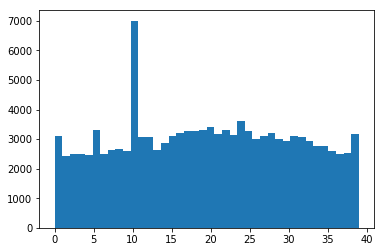

10 - Jail             5.740466
24 - RED-Illi         2.947275
20 - Free_Parking     2.787454
19 - ORG-NY           2.710411
5 - RR-Read           2.709592
22 - Chance2          2.699757
18 - ORG-Tenn         2.693200
17 - CC2              2.686643
25 - RR-B&O           2.670251
16 - ORG-StJames      2.630910
28 - UTL-Water        2.622714
39 - BLU-Boardwalk    2.593209
21 - RED-Kent         2.589111
23 - RED-Indiana      2.572719
0 - GO                2.557146
15 - RR-Penn          2.552229
27 - YEL-Vent         2.548951
31 - GRE-Pacific      2.539115
11 - PUR-StChar       2.528461
32 - GRE-NC           2.517806
12 - UTL-Elect        2.510429
26 - YEL-Atlantic     2.454697
29 - YEL-Marv         2.451418
30 - GoToJail         2.405521
33 - CC3              2.392407
14 - PUR-Virg         2.346510
35 - RR-SHLine        2.280942
34 - GRE-Penn         2.263730
8 - WHT-Verm          2.184229
13 - PUR-States       2.150626
7 - Chance1           2.149806
9 - WHT-Connec        2.132595
36 - Cha

In [16]:
# Frequency of spaces. If uniform, they'll all be 1/40 = 2.5%

freqs = pd.Series(test[0] % NUM_SPACES).value_counts().sort_index()
names = pd.Series(SPACES)[freqs.index.astype(int)]
freqs.index = [str(int(freqs.index[x])) + " - " + names[x] for x in range(len(freqs))]
plt.hist(test[0] % NUM_SPACES, bins=40)
plt.show()
freqs.sort_values(ascending=False) / len(test[0]) *100

Average Movement/turn: 9.428
Proportion that move over a full circle: 0.00757
Furthest Move: 86.0

Turn #18210: 
You have 1 get out of jail free card(s)
Starting at space 39 (172439): BLU-Boardwalk 
Rolled a dice total of 8
Double! #1
Moved to space 7 (172447): Chance1 
Checking Space...
Chance! Draw chance card!
Card Drawn: Advance to GO (Space 0)
Moved to space 0 (172480): GO 
Chance Deck: 10 of 16 cards left
Rolled a dice total of 7
Moved to space 7 (172487): Chance1 
Checking Space...
Chance! Draw chance card!
Card Drawn: Advance to RR-Read (Space 5)
Moved to space 5 (172525): RR-Read 
Chance Deck: 9 of 16 cards left

0.0    3621
2.0     117
3.0    4974
4.0    4953
5.0    9988
dtype: int64


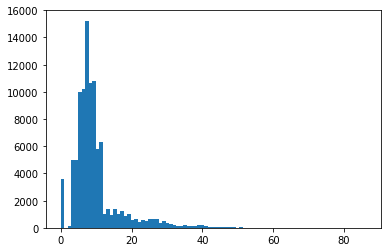

In [39]:
# Movement per Turn

print("Average Movement/turn: %.3f" % np.mean(test[1]))
print("Proportion that move over a full circle: %.5f" % np.mean(test[1] > 40))
print("Furthest Move: {}".format(max(test[1])))  # Furthest moved around board
print("\n" + test[6][np.argmax(test[1])])  # What turn that was

# Did we get negative movement? (Possible)
print(pd.Series(test[1]).value_counts().sort_index(0)[:5]) 

plt.hist(test[1], bins=int(max(test[1]))+1)
plt.show()


In [40]:
# Jail Statisitics

print("Proportion of turns in jail: %.4f" % test[2][0])
print("Prob(Staying in Jail):       %.4f" % test[2][1])  # All stats below are conditional on being in jail.
print("Prob(Paying to get out):     %.4f" % test[2][2])
print("Prob(Escaping by doubles):   %.4f" % test[2][3])
print("Prob(Use jail-free card):    %.4f" % test[2][4])
print("Prob(Thrown back into jail): %.4f" % test[2][5])  # Given in jail, chance of getting out and getting jailed again
print()

# 5 example Turns where the last statistic happened
for x in test[4][:5]:
    print(test[6][x])

Proportion of turns in jail: 0.0811
Prob(Staying in Jail):       0.4467
Prob(Paying to get out):     0.3282
Prob(Escaping by doubles):   0.0886
Prob(Use jail-free card):    0.1365
Prob(Thrown back into jail): 0.0178

Turn #1540: 
You have 0 get out of jail free card(s)
Starting at space 10 (14490): Jail 
You are Jailed!
You've rolled 1 out of a max of 2 rolls before you'll pay.
You got out of jail! You rolled a double! Move 12 spaces
Moved to space 22 (14502): Chance2 
Checking Space...
Chance! Draw chance card!
Card drawn: Go to Jail!
Moved to space 10 (14530): Jail 
You are now Jailed!
Chance Deck: 10 of 16 cards left
Back in Jail!
Skipped Go!
Next time you'll roll a max number of 0 times to get out of jail


Turn #3222: 
You have 2 get out of jail free card(s)
Starting at space 10 (30410): Jail 
You are Jailed!
You used a get out of Jail Free card! 1 jail-free cards left
You are out of Jail!
Rolled a dice total of 4
Double! #1
Moved to space 14 (30414): PUR-Virg 
Checking Space...
R

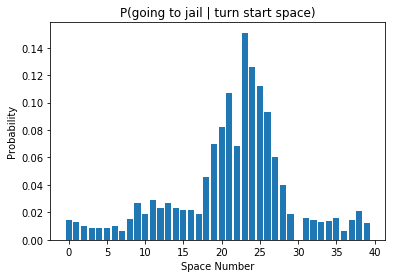

In [41]:
# Relationship between turn starting space and going to jail

# Based on given starting space, what's the probability of going to jail by end of turn?
# Out of all the times you've been on this space, here are the % that have gone to jail

s = pd.Series(test[3][0] % NUM_SPACES).value_counts()
s = s.append(pd.Series(0, index={GOTO_JAIL_SPACE})).sort_index(0)
s / (test[2][0]*nturns)
# plt.hist(test[3][0] % NUM_SPACES, bins=NUM_SPACES) # Unnormalized plot. Does not divide by frequencies
# plt.show()
plt.bar(np.arange(NUM_SPACES), s / freqs.values)
plt.title("P(going to jail | turn start space)")
plt.ylabel("Probability")
plt.xlabel("Space Number")
plt.show()

# Based on Last Space. Bug: Go to jail frequency should match number of spaces
# sl = pd.Series(test[3][1] % NUM_SPACES).value_counts() / (test[2][0]*nturns) # / freqs.values
# plt.hist(test[3][1] % NUM_SPACES, bins=NUM_SPACES)
# plt.show()

In [42]:
# Go Statistics

print("Collected Go Money: {} times".format(test[5][0]))
print("# of turns to passing Go ratio: %.3f" % (test[5][1]))


Collected Go Money: 19509 times
# of turns to passing Go ratio: 5.126


In [43]:
# Simulation: Turns required to land on all properties
# Note: this will not include the initial space. It will have to land on it again.

def updateList(targ_matrix, newsp, turn):
    for x in newsp:
        try:
            col_ind = np.where(targ_matrix[0] == x)[0][0]
            if targ_matrix[1, col_ind] == -1:
                targ_matrix[1, col_ind] = turn
        except IndexError:
            pass
    return targ_matrix

def hit_all_spaces(targets, curr_space=0):
    jailed = False
    jail_free = 0
    non_dubs = 0
    num_dubs = 0
    n = N()
    # all_spaces = []

    turn = 1
    chdeck = CHANCE_DECK[:]
    ccdeck = list(CC_DECK)
    targ_matrix = np.vstack((targets, np.repeat(-1, len(targets))))

    while -1 in targ_matrix[1]:
        turn_spaces = []
        if jailed:
            assert curr_space % NUM_SPACES == JAIL_SPACE, "ERROR: You must be on the jail space to be jailed"
        assert curr_space % NUM_SPACES != GOTO_JAIL_SPACE, "ERROR: You can't start on the Go to Jail space"

        if jail_free > 0 and jailed:
            jail_free -= 1
            jailed = False

        if jailed:
            if non_dubs < n:
                roll = rollDice()
                if roll[1]:
                    jailed = False
                    curr_space += roll[0]
                    turn_spaces.append(curr_space)
                    # Check Space
                    cs = checkSpace(curr_space, chdeck, ccdeck, jail_free)
                    if len(cs[0]) != 0:
                        curr_space = cs[0][-1]  # Last number of the sequence becomes current space
                    turn_spaces.extend(cs[0])
                    jailed = cs[1]
                    jail_free = cs[2]
                    non_dubs = 0
                    n = N()
                    updateList(targ_matrix, np.array(turn_spaces) % NUM_SPACES, turn)
                    # all_spaces.append(turn_spaces)
                    turn += 1
                    continue
                else:
                    non_dubs += 1
            else:
                jailed = False
                non_dubs = 0
                n = N()

        if not jailed:
            num_dubs = 0
            roll = rollDice()
            if roll[1]:
                num_dubs = 1
            curr_space += roll[0]
            turn_spaces.append(curr_space)
            cs = checkSpace(curr_space, chdeck, ccdeck, jail_free)
            if len(cs[0]) != 0:
                curr_space = cs[0][-1]  # Last number of the sequence becomes current space
            turn_spaces.extend(cs[0])
            jailed = cs[1]
            if jailed:
                updateList(targ_matrix, np.array(turn_spaces) % NUM_SPACES, turn)
                # all_spaces.append(turn_spaces)
                turn += 1
                continue
            jail_free = cs[2]

            while roll[1]:  # If you rolled a double
                roll = rollDice()
                if roll[1]:
                    num_dubs += 1
                if (num_dubs < 3):
                    curr_space += roll[0]
                    turn_spaces.append(curr_space)
                    # Check Space
                    cs = checkSpace(curr_space, chdeck, ccdeck, jail_free)
                    if len(cs[0]) != 0:
                        curr_space = cs[0][-1]  # Last number of the sequence becomes current space
                    turn_spaces.extend(cs[0])
                    jailed = cs[1]
                    if jailed:
                        break
                    jail_free = cs[2]
                else:  # JAILED
                    curr_space = goToSpace(curr_space, JAIL_SPACE)
                    turn_spaces.append(curr_space)
                    jailed = True
                    break
        updateList(targ_matrix, np.array(turn_spaces) % NUM_SPACES, turn)
        # all_spaces.append(turn_spaces)
        turn += 1
    return targ_matrix[-1], turn-1,  # all_spaces

In [44]:
# Example (Above)
# All properties have a "-" sign in them
properties = np.where([x.find('-') != -1 for x in SPACES])[0]

h = hit_all_spaces(properties)
print("Number of turns to hit all properties: {}".format(h[1]))
print("Turns until property is landed on:")
{SPACES[properties[x]] : h[0].transpose()[x] for x in range(len(properties)) }



Number of turns to hit all properties: 106
Turns until property is landed on:


{'BLU-Boardwalk': 6,
 'BLU-ParkPl': 10,
 'BRW-Baltic': 86,
 'BRW-Medit': 15,
 'GRE-NC': 5,
 'GRE-Pacific': 33,
 'GRE-Penn': 90,
 'ORG-NY': 8,
 'ORG-StJames': 27,
 'ORG-Tenn': 13,
 'PUR-StChar': 7,
 'PUR-States': 106,
 'PUR-Virg': 2,
 'RED-Illi': 33,
 'RED-Indiana': 68,
 'RED-Kent': 63,
 'RR-B&O': 4,
 'RR-Penn': 23,
 'RR-Read': 22,
 'RR-SHLine': 27,
 'UTL-Elect': 31,
 'UTL-Water': 9,
 'WHT-Connec': 30,
 'WHT-Orient': 15,
 'WHT-Verm': 1,
 'YEL-Atlantic': 20,
 'YEL-Marv': 18,
 'YEL-Vent': 14}

Average # of turns 124.709
Fewest # turns out of 1000 trials: 53


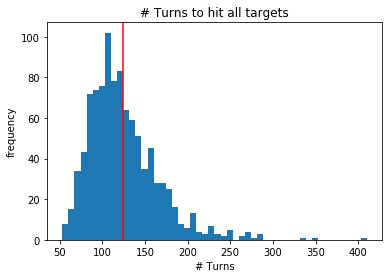

About 90% of turns are less than 176.0


In [45]:
# Repeated Trials

ntrials = 1000 # 1000 Takes ~ 20 secs...
results = [hit_all_spaces(properties) for x in range(ntrials)]  
max_turns = [x[1] for x in results]  # Strips the maximum numbers

# Stats
print("Average # of turns %.3f" % np.mean(max_turns))  
print("Fewest # turns out of %.0f trials: %.0f" % (ntrials, np.min(max_turns)))
plt.hist(max_turns, bins=50)
plt.xlabel("# Turns")
plt.ylabel("frequency")
plt.axvline(np.mean(max_turns), color='red')
plt.title("# Turns to hit all targets")
plt.show()

perc = 90
print("About %.0f%% of turns are less than %.1f" % (perc, np.percentile(max_turns, 90)))

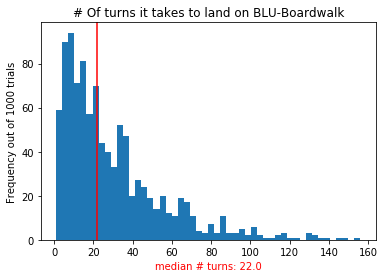

0.36

In [46]:
# Viewing the distrubition for each space

def first_turn(space, stats):
    assert space in stats, "ERROR: Must specify an existing space number"
    name = "# Of turns it takes to land on " + SPACES[space]
    med = np.median(stats[space])
    plt.hist(stats[space], bins=50)
    plt.title(name)
    plt.ylabel('Frequency out of ' + str(len(stats[space])) + " trials")
    plt.axvline(med, color='red')
    plt.xlabel('median # turns: ' + str(med), color='red')
    plt.show()

# Using the previous results, we can extract data from each space
prop_matrix = np.array([[x[0][i] for x in results] for i in range(len(properties))])
prop_stats = {properties[x]: prop_matrix[x] for x in range(len(properties))}
    
# Example: Boardwalk
first_turn(39, prop_stats)
np.mean(prop_stats[39] <= 15) # About 36% are within 15 turns

In [149]:
# Space that takes the longest (median) to land on

meds = pd.Series({SPACES[properties[x]]: np.median(prop_matrix[x]) for x in range(len(properties))})
meds.sort_values(ascending=False)

BRW-Medit        30.0
BLU-ParkPl       29.0
BRW-Baltic       26.0
GRE-Penn         25.0
PUR-States       24.5
WHT-Connec       24.0
GRE-NC           24.0
RR-SHLine        24.0
YEL-Vent         23.0
YEL-Marv         23.0
GRE-Pacific      23.0
PUR-Virg         23.0
BLU-Boardwalk    23.0
YEL-Atlantic     22.0
WHT-Verm         21.5
RED-Indiana      21.0
RED-Kent         21.0
RR-B&O           21.0
RR-Penn          21.0
ORG-StJames      21.0
UTL-Water        21.0
WHT-Orient       21.0
UTL-Elect        20.0
PUR-StChar       19.0
ORG-NY           19.0
RED-Illi         18.5
ORG-Tenn         18.0
RR-Read          18.0
dtype: float64